In [1]:
!pip install peft==0.10.0
!pip install accelerate==0.34.2
!pip install --upgrade huggingface-hub
!pip install sentencepiece
!pip install transformers==4.45.2
!pip install sentence-transformers==3.1.1
!pip install protobuf
!pip install datasets
!pip install bitsandbytes
!pip install spacy
!python -m spacy download en

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 345.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 132.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 174.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 130.8 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.4.1
    Uninstalling safetensors-0.4.1:
      Successfully uninstalled safetensors-0.4.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.2
    Uninstalling huggingface-hub-0.20.2:
      Successfully uninstalled huggingface-hub-0.20.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 199.6 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.5.2
    Uninstalling accelerate-1.5.2:
      Successfully uninstalled accelerate-1.5.2
   ━━━━━━━━━━━━━━━━

In [ ]:
import json
import torch
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import LlamaTokenizer, LlamaForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSequenceClassification, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from datasets import Dataset, DatasetDict
from huggingface_hub import login
import re
login(token='secret')

with open('dataset.json', 'r') as file:
    data = json.load(file)

with open('new_test_dataset.json', 'r', encoding="utf-8") as file:
    t_data = json.load(file)

def shorten_article(entry):
    entry["article"] = entry["article"][:int(len(entry["article"])*0.5)]
    cleaned_text = re.sub(r'\b(Donald|donald|Trump|trump|former|Former|president|President|Joe|joe|Biden|biden)\b', '', entry["article"])
    entry["article"] = cleaned_text.strip()
    return entry

#data = [shorten_article(entry) for entry in data]

df = pd.DataFrame(data)
#df = df.sample(frac=0.1,random_state=42)
print(df)

tdf = pd.DataFrame(t_data)

label_mapping = {"left": 0, "lean-left": 1, "lean-right": 2, "right": 3}
df['label'] = df['label'].map(label_mapping)
tdf["label"] = tdf['label'].map(label_mapping)

train_size = 0.6
temp_size = 0.4
val_size = 0.5
test_size = 0.5
df_train, df_temp = train_test_split(df, train_size=train_size, test_size=temp_size, random_state=42)
df_val, df_test = train_test_split(df_temp, train_size=val_size, test_size=test_size, random_state=42)
dataset_train = Dataset.from_pandas(df_train.reset_index(drop=True))
dataset_val = Dataset.from_pandas(df_val.reset_index(drop=True))
dataset_test = Dataset.from_pandas(df_test.reset_index(drop=True))
dataset_new_test = Dataset.from_pandas(tdf.reset_index(drop=True))

                                                 article       label
0      If Donald Trump loses November’s election, it ...        left
1      Donald Trump is not a rational choice for cons...        left
2      The outsider candidate has money, a running ma...        left
3      No recent Democratic president has faced such ...        left
4      The conservative justices have shown they are ...        left
...                                                  ...         ...
13898  ATLANTA — A Republican-led group is challengin...  lean-right
13899  PRAIRIE DU CHIEN, Wis. — A day after Vice Pres...  lean-right
13900  Donald Trump says newly released statistics fr...  lean-right
13901  OPINION: Colombian President Gustavo Petro, in...  lean-right
13902  Vice President Kamala Harris is closing out th...  lean-right

[13903 rows x 2 columns]


In [3]:
dataset = DatasetDict({
    'train': dataset_train,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'label'],
        num_rows: 8341
    })
    val: Dataset({
        features: ['article', 'label'],
        num_rows: 2781
    })
    test: Dataset({
        features: ['article', 'label'],
        num_rows: 2781
    })
})

In [4]:
df_train.label.value_counts(normalize=True)

label
3    0.333893
1    0.313512
2    0.294689
0    0.057907
Name: proportion, dtype: float64

In [5]:
class_weights = (1/df_train.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.6432, 0.1188, 0.1264, 0.1116])

In [ ]:
#model_name = "google/gemma-2-2b"
model_name = "tiiuae/Falcon3-1B-Instruct"
#model_name = "microsoft/Phi-3.5-mini-instruct"
#model_name = "meta-llama/Llama-3.2-3B-Instruct"

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.bfloat16
)

In [ ]:
lora_config = LoraConfig(
    r = 16,
    lora_alpha = 8,
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05,
    bias = 'none',
    task_type = 'SEQ_CLS'
)

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=4
)

model

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at tiiuae/Falcon3-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(131072, 2048)
    (layers): ModuleList(
      (0-17): 18 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((

In [10]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(131072, 2048)
    (layers): ModuleList(
      (0-17): 18 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((

In [11]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(131072, 2048)
        (layers): ModuleList(
          (0-17): 18 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [13]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [14]:
max_len = 512
def llama_preprocessing_function(examples):
    return tokenizer(examples['article'], truncation=True, max_length=max_len)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8341 [00:00<?, ? examples/s]

Map:   0%|          | 0/2781 [00:00<?, ? examples/s]

Map:   0%|          | 0/2781 [00:00<?, ? examples/s]

In [15]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").long()

        outputs = model(**inputs)

        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [18]:
training_args = TrainingArguments(
    output_dir = 'sequence_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

/opt/miniconda3/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights = class_weights
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_432/2851958097.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


In [20]:
import torch.nn.functional as F
train_result = trainer.train()

/opt/miniconda3/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.178300,0.156174,0.959367,0.959292,0.959402,0.959367
2,0.089600,0.126541,0.969076,0.969041,0.969128,0.969076


/opt/miniconda3/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
label_mapping = {0 : 'left', 1: 'lean-left', 2: 'lean-right', 3: 'right'}
maptwo = {"left": 0,"lean-left": 1,"lean-right":2,"right":3}
def make_predictions(model, df):


  sentences = df.article.tolist()

  batch_size = 32

  all_outputs = []

  for i in range(0, len(sentences), batch_size):
      batch_sentences = sentences[i:i + batch_size]

      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])

  final_outputs = torch.cat(all_outputs, dim=0)
  df['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df['predictions']=df['predictions'].apply(lambda l:label_mapping[l])

In [22]:
def get_performance_metrics(df_test):
  y_test = df_test.label.round()
  y_pred = df_test.predictions.map(maptwo)
  print(f"comparing test {y_test} and pred {y_pred}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
make_predictions(model,df_val)

get_performance_metrics(df_val)
df_val

In [ ]:
make_predictions(model,df_test)

get_performance_metrics(df_test)
df_test

In [ ]:
make_predictions(model,tdf)

get_performance_metrics(tdf)
tdf

In [ ]:
import spacy
from tqdm import tqdm

device = torch.device("cuda")

nlp = spacy.load("en_core_web_sm")

model.eval()

def classify_sentences(text, model, tokenizer):
    sentences = [sent.text for sent in nlp(text).sents]
    inputs = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = probs.argmax(dim=-1).tolist()
    scores = probs.max(dim=-1).values.tolist()
    return list(zip(sentences, labels, scores))

all_sentence_results = []
for article in tqdm(df_test["article"], desc="Processing Articles", unit="article"):
    try:
        all_sentence_results.extend(classify_sentences(article, model, tokenizer))
    except:
        continue

sentence_df = pd.DataFrame(all_sentence_results, columns=["Sentence", "Predicted Label", "Score"])

pd.set_option("display.max_colwidth", None)

Processing Articles: 100%|██████████| 13903/13903 [2:21:08<00:00,  1.64article/s]  


In [26]:
print(all_sentence_results)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
top_n = 15
for label, group in sentence_df.groupby("Predicted Label"):
    sorted_group = group.sort_values(by="Score", ascending=False).head(top_n)
    print(f"\nLabel {label}:")
    print(sorted_group[["Sentence", "Score"]].to_string(index=False))


Label 0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Sentence    Score
                                                                                                                                              Trump’s loyalists, in particular, have spent the past few years haunted by a counterfactual: Had the president run a reelection campaign that was even slightly more effective—a campaign that didn’t go broke that fall; a campaign that didn’t employ unskilled interlopers in crucial 

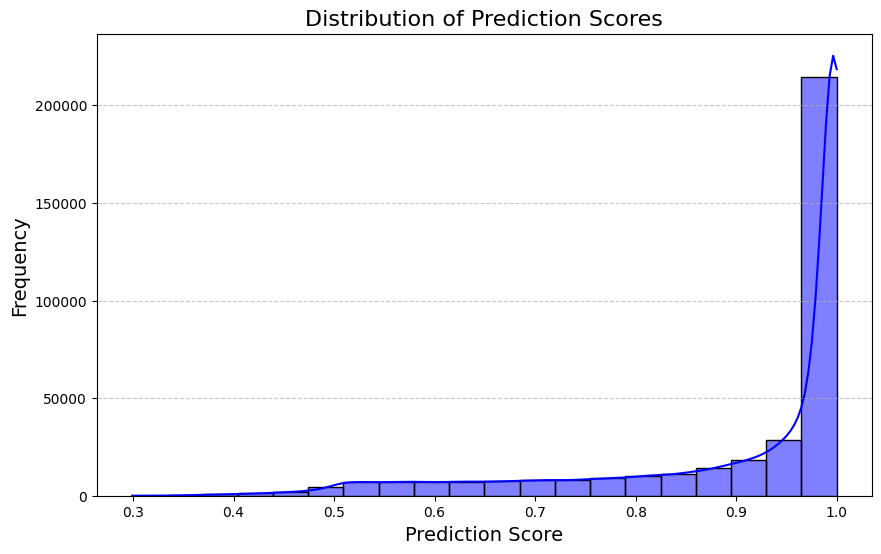

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sentence_df["Score"], bins=20, kde=True, color="blue")

plt.xlabel("Prediction Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Prediction Scores", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [24]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 133439458GF
  train_loss               =      0.1369
  train_runtime            =  3:09:16.07
  train_samples            =       11483
  train_samples_per_second =       2.022
  train_steps_per_second   =       0.253


In [25]:
trainer.save_model("saved_model")